# Финал!

## Шаг в прошлое. В предыдущих сериях...

In [1]:
import pandas as pd
import numpy as np
import json
import pymorphy2
import warnings
warnings.filterwarnings('ignore')
import enchant

from sklearn.model_selection import train_test_split

В решении используется библиотека `enchant`. Она используется для проверки слов на спеллинг, и, как следствие, необходима для проверки слов на опечатки. Тем неменее, ее подгрузка и установка предполагает дополнительные хитрые действия. Чтобы библиотека подружилась с русским языком, в её структуру необходимо подгрузить два файла: ru_RU.aff, ru_RU.dic. [Например отсюда](https://github.com/LibreOffice/dictionaries/blob/master/ru_RU/ru_RU.dic). Эти файлы необходимо положить внутрь папок библиотеки к другим словарям, которые там уже есть. Для наглядности, можно посмотреть вот [сюда](https://vc.ru/dev/174452-kak-proverit-pravopisanie-s-pomoshch-python-pyenchant) Из этого следует, что решение доступно для запуска на локальном компьютере, но не на сервере (да, google colab, про тебя говорим), так как добраться до места хранения файлов в виртуальной машине проблематично.

В моем случае, файлы необходимо было вложить вот сюда: `C:\вставьте свою путь дальше, до папки, куда скачиваются библиотеки\enchant\data\mingw64\share\enchant\hunspell`

In [2]:
from pymorphy2 import MorphAnalyzer
morph = MorphAnalyzer()

dictionary_big = enchant.Dict('ru_RU')

In [3]:
# Подгружаем данный в задании файл
with open('sample.json', 'r', encoding='UTF-8') as f:
    jj_list = json.load(f)
    
data = pd.DataFrame(columns = ['id', 'text'])

for js in jj_list:
    data = data.append(js, ignore_index = True)

### 1.1. Создаем пайплайн обработки текстовых данных

In [4]:
"""
Функция для поиска имен собственных в тексте. Заметим, что здесь игнорируются те слова, которые начинают предложения/
Исходя из предположения, что в данных находятся несколько предложений, подвергшихся рерайтингу, и использованию в них
одних и тех же слов (в том числе имен собственных), исследовательская группа предполагает, что систематический неучет
слов, начинающих предложения, не будет существенным недочетом. Однако, можем отметить, что данное ограничение для модели
нуждается в более гибкой обработке и улучшении

"""
def find_names(TEXT_SERIES, names):
    all_names = set()
    for string in TEXT_SERIES.str.split(' '):
        names = [i for i in string if i[:1].isupper()]
        for n in names[1:]:
            all_names.add(morph.normal_forms(n.lower())[0])
    return all_names

"""
Функция для создания словаря тех слов, которые встречаются в данных.
Из словаря исключены слова собственные, так как они могут быть ошибочно причисленны к словам с опечатками
""" 

def create_dictionary(text_series, d):
    for string in text_series.str.split(' '):
        for word in string:
            if (word not in all_names):
                d.add(word)
    return d

In [5]:
def preprocessing_texts(df_PRACTISE):
    # Обрабатываем тексты
    df_PRACTISE['text'] = df_PRACTISE['text'].str.lower().replace('\n', ' ', regex = False).str.replace(r'[^\w\s\-]+', '', regex=True).str.strip()
    # Удаляем получившиеся полностью пустые комментарии, они нам все равно не помогут
    df_PRACTISE = df_PRACTISE[df_PRACTISE['text'].astype(bool) == True]
    # Удаляем пропуски в колонке тексте
    df_PRACTISE.dropna(subset=['text'], inplace=True)
    return df_PRACTISE

In [6]:
# Функция для создания нормализации слов, которые не являются именами собственными

def normalize(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word not in all_names):
                word = morph.normal_forms(word)[0]
            clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

In [7]:
data = preprocessing_texts(data)

In [8]:
all_names = set()
all_names = find_names(data['text'], all_names)

In [9]:
#создание дополнительной колонки с текстом, состоящих из нормализованных слов
data['norm_text'] = data['text']
data['norm_text'] = normalize(data['norm_text'])

### 1.2. Поиск и замена опечаток.

In [10]:
"""
Функция для подбора правильно написанных слов из словаря. Исследовательская группа посчитала, что сравнение со словарем,
созданном на основе исходных данных достаточно, так как слова с ошибками -- производные из существующих (и свидетельствуют
о наличии рерайтинга). Заметим, что в созданном словаре сейчас также находятся слова с ошибками.
Поэтому, при подборе правильного слово на место слова с опечаткой мы выбираем слово со вторым минимальным 
расстоняием Ливенштейна (справедливо, что это будет первое ненулевое значение в массиве).
"""
def top_levenshtain(word, dictionary):
    top = pd.DataFrame(columns = ['word_from_dict','lev_dist'])
    for w in dictionary:
        llev = enchant.utils.levenshtein(word, w)
        top = top.append({'word_from_dict' : w, 'lev_dist': llev}, ignore_index=True)
    top = top.sort_values(by=['lev_dist'])
    ww = top.iloc[1]['word_from_dict']
    return ww


# Замена слов с опечатками в исходных текстах. Заметим, что слова сразу заменяются на нормализированную форму
def change_words(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word in mistakes and word not in all_names):
                word = correct[word]
            clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

def detect_mistakes(data):
    dictionary = set()
    dictionary = create_dictionary(data['norm_text'], dictionary)
    
    # Создание списка слов с опечатками
    mistakes = []
    for i in dictionary:
        if not dictionary_big.check(i):
            mistakes.append(i)
            
    # Для удобного обращения, создаем хэш-таблицу, чтобы быстро заменять слова с опечаткой на корректное написнаие.
    correct = dict()
    for m in mistakes:
        ww = top_levenshtain(m, dictionary)
        correct[m] = ww
        
    return dictionary, mistakes, correct

In [11]:
dictionary, mistakes, correct = detect_mistakes(data)

data['text'] = change_words(data['text'])
data['norm_text'] = change_words(data['norm_text'])

Заметим, что из классического джентльменского набора предобработки текстов исключен этап удаления стоп-слов. Это было сделано по нескольким причинам. Во-первых, такие слова скорее будут свидетельствовать о схожести текстов между собой из-за специфики полученных в задании данных. Во-вторых, данные предложения достаточно короткие сами по себе, так что надобности сократить их ещё больше -- нет.

Другая проблема состоит в том, что в них достаточно много похожих слов, которые не входит в стоп-список, но будут встречаться в различных не связанных между собой предложениях. Это могут быть не стоп-слова, а более специфичные. Решим эту проблему на следующем шаге.

### 1.3. Частотность слов

In [12]:
from collections import Counter

In [13]:
# Замена слов с опечатками в исходных текстах. Заметим, что слова сразу заменяются на нормализированную форму
def remove_common_words(TEXT_SERIES):
    text_series = TEXT_SERIES
    i = 0
    for string in TEXT_SERIES.str.split(' '):
        clean_text = []
        for word in string:
            if (word not in too_common):
                clean_text.append(word)
        text = " ".join(x for x in clean_text)
        text_series.iloc[i] = text
        i = i + 1
    return text_series

def makeSpecialData(data):
    mostcommon = data.most_common()
    special_data = pd.DataFrame({
        'Word': [element[0] for element in mostcommon],
        'Frequency': [element[1] for element in mostcommon]})
    return special_data

In [14]:
#Подсчитываем частоту слов
all_words = Counter()
for string in data['norm_text']:
    words = string.split(' ')
    words_count = Counter(words)
    all_words = all_words + words_count
    
# создаем из объекта counter датафрейм
table_all = makeSpecialData(all_words)

In [15]:
"""
Берем первых 5% самых частых слов с целью очищения данных от них. Это необходимо, чтобы кластеризация прошла лучше:
предложения, которые не являются рерайтингом, но имеющие общие слова будут объединяться в случайные кластеры
с меньшей вероятностью.

Количество этих слов варьируется. Предположительно: 
"""
red_line = round(0.05*len(table_all))
too_common = table_all.head(red_line)['Word'].to_list()

all_ = table_all['Frequency'].sum()
all_comm = table_all['Frequency'][:red_line].sum()

print(all_, all_comm, all_comm/all_)

2254 1086 0.481810115350488


## Кое-что новое!

In [16]:
"""
Получаем текст, который подвергся следующей предобработке:
1. Нормализация
2. Замена опечаток
3. Удаление самых частых слов

Это текст, который наиболее сильным образом отличается от исходного.
"""

data['norm_text'] = remove_common_words(data['norm_text'])



"""
Получаем текст, который подвергся следующей предобработке:
1. Замена опечаток
2. Удаление самых частых слов

Это текст который меньше отличается от исходного
"""
data['unique_text'] = data['text']
data['unique_text'] = remove_common_words(data['unique_text'])



"""
Получаем текст, который подвергся следующей предобработке:
1. Нормализация
2. Замена опечаток

Этот текст почти не отличается от исходного. Данный вид обработки был добавлен на этапе финала
"""
data['ttext'] = data['norm_text']

Исходный текст, который содержится в колонке `data['text']` -- текст, в котором опечатки заменены на корректные слова. Таким образом, сейчас в датасете есть 4 текстовые колонки, содержащие текст разного уровня обработки, с целью понять, какой из них лучше.

### TF-Idf

В ходе анализа были построены различные варианты матрицы `Tf-idf`. Тексты различались по степени обработки (см. выше). Также были построены матрицы `Tf-idf`, использующие только униграммы (или отдельные слова) и униграммы с биграммами. Исследовательской группой было принято решение оставить исключительно второй вариант (с униграммами и биграммами), так как рерайтинг часто подразумевает использование тех же слов, но в другом порядке. 

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans, AffinityPropagation, AgglomerativeClustering

In [18]:
# Сделаем Tfidf матрицу по униграммам и биграммам
tfidf_vectorizer_bigrams = TfidfVectorizer(ngram_range=(1, 2))

# Применение TF-IDF к текстовым данным
tfidf_bi_text = tfidf_vectorizer_bigrams.fit_transform(data['text'].to_list())
tfidf_bi_ttext = tfidf_vectorizer_bigrams.fit_transform(data['ttext'].to_list())
tfidf_bi_unique = tfidf_vectorizer_bigrams.fit_transform(data['unique_text'].to_list())
tfidf_bi_norm = tfidf_vectorizer_bigrams.fit_transform(data['norm_text'].to_list())

In [41]:
ht_models = dict()

ht_models['tfidf_bi_text'] = tfidf_bi_text
ht_models['tfidf_bi_ttext'] = tfidf_bi_ttext
ht_models['tfidf_bi_unique'] = tfidf_bi_unique
ht_models['tfidf_bi_norm'] = tfidf_bi_norm

In [42]:
tfidf_bi_text, tfidf_bi_ttext, tfidf_bi_unique, tfidf_bi_norm

(<412x1681 sparse matrix of type '<class 'numpy.float64'>'
 	with 3627 stored elements in Compressed Sparse Row format>,
 <412x882 sparse matrix of type '<class 'numpy.float64'>'
 	with 1857 stored elements in Compressed Sparse Row format>,
 <412x1454 sparse matrix of type '<class 'numpy.float64'>'
 	with 2781 stored elements in Compressed Sparse Row format>,
 <412x882 sparse matrix of type '<class 'numpy.float64'>'
 	with 1857 stored elements in Compressed Sparse Row format>)

### Кластеризация. Здесь тоже есть кое-что новое

Одна из самых сложный подзадач при задаче кластеризации -- это оптимальный подбор количества кластеров. Можно подбирать их на глаз, но мы постарались автоматизировать этот подход путем перебора и сравнения специальных метрик.
Подробные описнаия использованных метрик можно найти [здесь, но на R](https://uc-r.github.io/kmeans_clustering#:~:text=The%20average%20silhouette%20method%20computes,of%20possible%20values%20for%20k.2) и [здесь](https://stackoverflow.com/questions/19197715/scikit-learn-k-means-elbow-criterion).

Помимо самого классического способа адгоритма кластеризации `KMeans`, который представляет собой вероятностный алгоритм, и может плохо работать из-за неудачной первичной инициализации, исследовательская группа приняла решение использовать метод `AgglomerativeClustering`, так как он не только более контролируемый с точки зрения "неудачной инициализации" (в решении будет использован агломеративный иерархический подход, который предполагает наличие на первом шаге `n` независимых друг от друга кластеров). Он также будет более интуитивен, так как визуализация буквально показывает процесс объединения изначальных кластеров во все более большие.

Идейно, поиск рерайтинга означает нахождение таких групп предложений, которые очень похожи друг с другом. Агломеративный иерархический подход концептуально более подходит под задачу "обеспечения большей степени сходства внутри кластера", чем вне его. Такая концепция буквально отражена в визуальном представлении иерархической кластеризации -- дендрограмме -- где более низкие соединения будут свидетельствовать о большей схожести объектов.

Минусом алгоритмов иерархической кластеризации является то, что они легко переобучаемы. Также количество кластеров будет определяться вручную путем визуального разрезания дендрограммы на нужном уровне.

Также, помимо нового алгоритма кластеризации, будет использован более интерпретируемый способ внутренней оценки качества кластеризации: `davies_bouldin_score`. Чем ближе данный критерий к единице, тем лучше проведена кластеризация.

Также будет произведена внешняя оценка качества кластеризации, так как благодаря усилиям членов команды данные были размечены для возможности проведения кластеризации.

In [43]:
import matplotlib.pyplot as plt
from sklearn.metrics import davies_bouldin_score

In [44]:
def get_best_k(data, max_k, min_k=2):
    db_scores = pd.DataFrame(columns=['n_clusters', 'davies_bouldin_score'])
    for k in range(min_k, max_k):
        algo = AgglomerativeClustering(n_clusters=k, linkage="ward").fit(data)
        labels = algo.labels_
        db = davies_bouldin_score(data, labels)
        db_scores = db_scores.append({'n_clusters': k, 'davies_bouldin_score': db}, ignore_index = True)
        
    return db_scores

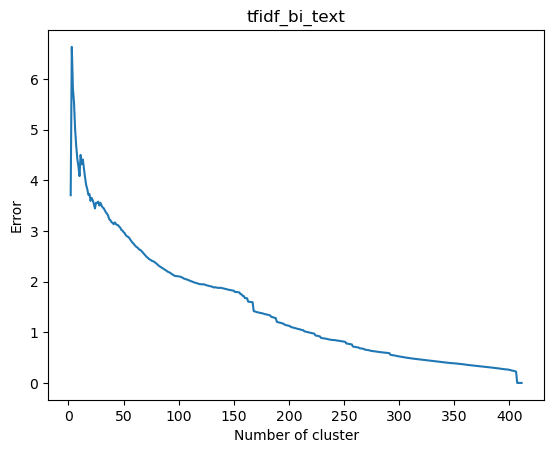

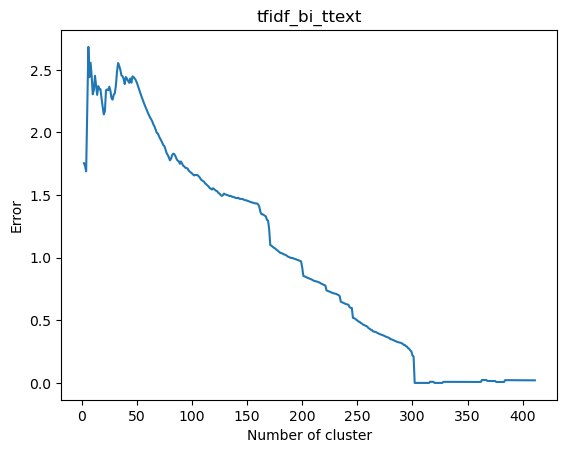

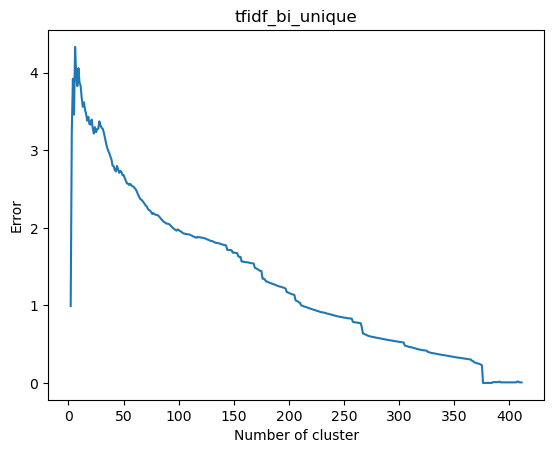

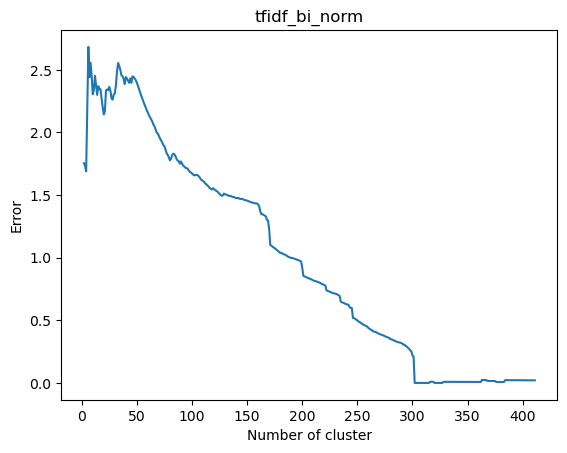

In [45]:
max_k = len(data)

for d in ht_models.keys():
    scores = get_best_k(ht_models[d].toarray(), max_k)
    plt.figure()
    plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
    plt.xlabel("Number of cluster")
    plt.ylabel("Error")
    plt.title(f'{d}')
    plt.show()

Визуализация дает представление о том, как и с какой скоростью изменяется `davies_bouldin_score`. Далее будем рассматривать подробнее зону от 150 до 300 кластеров, так как там визуально происходит все самое интересное. Больше кластеров, даже при условии очень низкого значения `davies_bouldin_score`, так как высок риск переобучения.

Заметим также, что графики моделей `tfidf_bi_ttext` и `tfidf_bi_norm` идентичны, а значит далее имеет смысл рассматривать только один из данных способов предобработки. Пусть, это будет `tfidf_bi_norm`.


In [51]:
ht_models.pop('tfidf_bi_ttext')

KeyError: 'tfidf_bi_ttext'

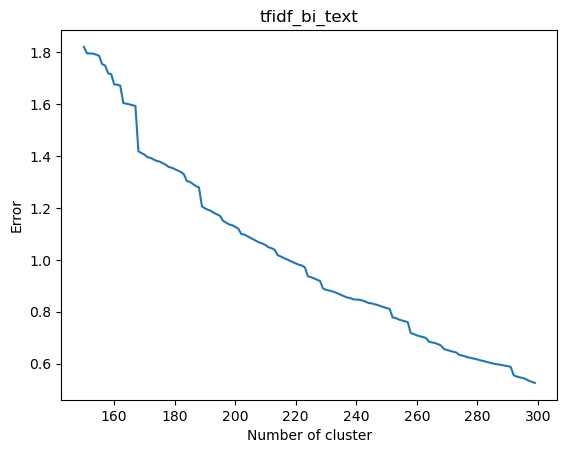

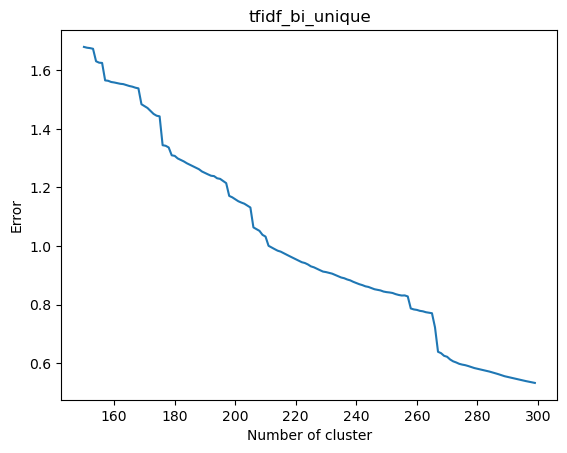

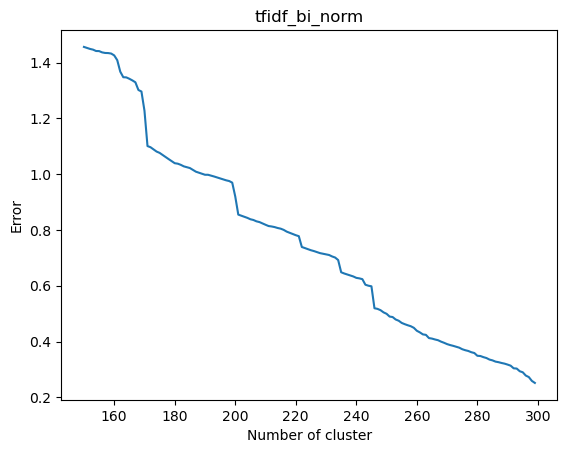

In [47]:
max_k = 300
min_k = 150

for d in ht_models.keys():
    scores = get_best_k(ht_models[d].toarray(), max_k, min_k)
    plt.figure()
    plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
    plt.xlabel("Number of cluster")
    plt.ylabel("Error")
    plt.title(f'{d}')
    plt.show()

Заметно, что значительное изменение в значении `davies_bouldin_score` у второй модели происходит в районе 265 классов, в то время как у первой и третьей модели -- в районе 245. Рассмотрим каждый из них подробнее. Так же заметим, что значение `davies_bouldin_score` в целом ниже у второй модели, чем у первой.

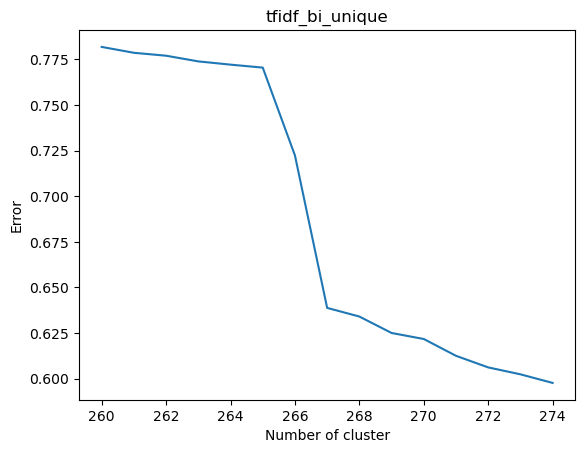

In [52]:
max_k = 275
min_k = 260
scores = get_best_k(ht_models['tfidf_bi_unique'].toarray(), max_k, min_k)
plt.figure()
plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.title('tfidf_bi_unique')
plt.show()

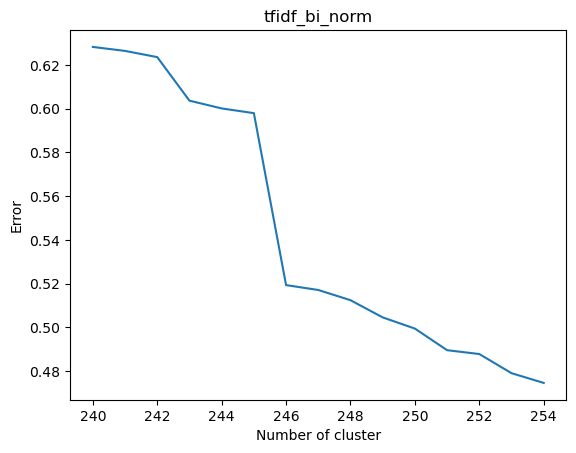

In [53]:
max_k = 255
min_k = 240
scores = get_best_k(ht_models['tfidf_bi_norm'].toarray(), max_k, min_k)
plt.figure()
plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.title('tfidf_bi_norm')
plt.show()

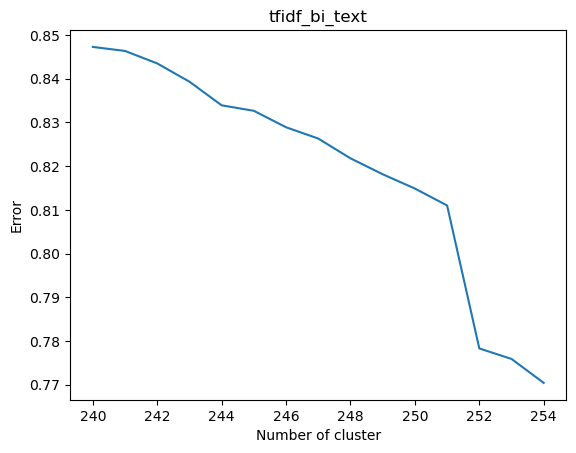

In [55]:
max_k = 255
min_k = 240
scores = get_best_k(ht_models['tfidf_bi_text'].toarray(), max_k, min_k)
plt.figure()
plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
plt.xlabel("Number of cluster")
plt.ylabel("Error")
plt.title('tfidf_bi_text')
plt.show()

In [63]:
num_clusters_u = 267
agg = AgglomerativeClustering(n_clusters=num_clusters_u, compute_distances=True)
agg_unique = agg.fit(tfidf_bi_unique.toarray())

In [64]:
num_clusters_n = 247
agg = AgglomerativeClustering(n_clusters=num_clusters_n, compute_distances=True)
agg_norm = agg.fit(tfidf_bi_norm.toarray())

In [69]:
num_clusters_t = 252
agg = AgglomerativeClustering(n_clusters=num_clusters_t, compute_distances=True)
agg_text = agg.fit(tfidf_bi_text.toarray())

In [70]:
labels = agg_unique.labels_
davies_bouldin_score(tfidf_bi_unique.toarray(), labels)

0.6387968720054961

In [71]:
labels = agg_norm.labels_
davies_bouldin_score(tfidf_bi_norm.toarray(), labels)

0.5170920935688527

In [72]:
labels = agg_text.labels_
davies_bouldin_score(tfidf_bi_text.toarray(), labels)

0.7782769359483488

In [73]:
def create_data(kmeans_, data, num_clusters):
    dataF = pd.DataFrame(columns=["id", "text", "cluster_id"])
    dataF['id'] = data['id']
    dataF['text'] = data['text']
    dataF["cluster_id"] = 0
    
    for cluster_id in range(num_clusters):
        cluster_indices = np.where(kmeans_.labels_ == cluster_id)[0]
        for idx in cluster_indices:
            dataF["cluster_id"][idx] = cluster_id + 1
    dataF = dataF.sort_values(by='cluster_id')
    dataF = dataF.reset_index(drop=True)
    return dataF

In [78]:
agg_norm_data = create_data(agg_norm, data, num_clusters_n)
agg_unique_data = create_data(agg_unique, data, num_clusters_u)
agg_text_data = create_data(agg_text, data, num_clusters_t)

In [79]:
agg_norm_data.to_csv('agg_norm_data_final.csv')
agg_unique_data.to_csv('agg_unique_data_final.csv')
agg_text_data.to_csv('agg_text_data_final.csv')

Таким образом, получены ещё 3 списка кластеров

### Проверка с помощью размеченных данных!!

In [80]:
data_labels = pd.read_excel('case_labels.xlsx', index_col = 0)
data_labels = data_labels.drop(labels=['Столбец1', 'Столбец2'], axis=1)

In [81]:
y_true = data_labels['cluster_id']

In [82]:
from sklearn.metrics import completeness_score

In [83]:
print(completeness_score(y_true, agg_norm.labels_))
print(completeness_score(y_true, agg_unique.labels_))
print(completeness_score(y_true, agg_text.labels_))

0.9064710320779292
0.9080814575160536
0.9070367712334514


Видно, что у обоих алгоритмов весьма высокая полнота, однако у модели, предсказывающей по тексту, который был очищен от самых частых слов и опечаток полнота выше:)

Для сравнения посмотрим на результаты, полученные на промежуточном этапе (с помощью алгоритма k_means)

In [84]:
num_clusters = 253
kmeans = KMeans(n_clusters=num_clusters, max_iter=1000, random_state=100)

kmeans_text = kmeans.fit(tfidf_bi_text)
kmeans_norm = kmeans.fit(tfidf_bi_norm)
kmeans_unique = kmeans.fit(tfidf_bi_unique)

In [85]:
print(completeness_score(y_true, kmeans_text.labels_))
print(completeness_score(y_true, kmeans_norm.labels_))
print(completeness_score(y_true, kmeans_unique.labels_))

0.9068956683487476
0.9068956683487476
0.9068956683487476


## P.S. Попытка в Word2Vec

In [21]:
import gensim.downloader
from gensim.models import Word2Vec

In [22]:
ru_model = gensim.downloader.load("word2vec-ruscorpora-300")

Особенностью единственного огромного корпуса русского языка -- `word2vec-ruscorpora-300`, используемого в `Word2Vec` является разметка слов на части речи. Так что, чтобы предобученная модель (а она необходима, потому как наши данные излишне малы) сработала, необходимо наделить данной разметкой и наши слова. Ниже -- необходимые функции:

In [23]:
def norm(sentence):
    normal_sentence = []
    list_sent = sentence.split(' ')
    for word in list_sent:
        normal_word = morph.parse(word)[0].normal_form

#         if word not in russian_stopwords:
        normal_sentence.append(normal_word)
    return normal_sentence

def norm_tags(sentence_list):
    tagged_sentence = []
    for word in sentence_list:
        if (morph.parse(word)[0].tag.POS):
            word_tagged = word + '_' +  morph.parse(word)[0].tag.POS
            tagged_sentence.append(word_tagged)
    return tagged_sentence

def tags(text_col):
    text_col = text_col.apply(lambda x: norm_tags(x))
    text_col = text_col.replace([], np.nan)
    return text_col

def make_prep_norm(text_col):
    text_col = text_col.str.lower().str.replace('\n', ' ', regex=False).str.replace(' +', ' ')
    text_col = text_col.apply(lambda x: re.sub('[^А-Яа-я]+', ' ', x))
    text_col = text_col.str.strip()
    text_col = text_col.apply(lambda x: norm(x))
    text_col = text_col.replace([], np.nan)
    return text_col

In [35]:
def vectorize(sent):
    return ru_model.get_mean_vector(sent)

In [25]:
def vectorize2(docs, model):
    features = []
    for tokens in docs:
        zero_vector = np.zeros(model.vector_size)
        vectors = []
        for token in tokens:
            if token in model.wv:
                try:
                    vectors.append(model.wv[token])
                except KeyError:
                    continue
        if vectors:
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            features.append(avg_vec)
        else:
            features.append(zero_vector)
    return features

In [29]:
data['norm_text_list'] = data['norm_text'].apply(lambda x: x.split(' '))
data['unique_text_list'] = data['unique_text'].apply(lambda x: x.split(' '))
data['text_list'] = data['text'].apply(lambda x: x.split(' '))

In [31]:
data = data.drop(labels=['ttext', 'ttext_list'], axis = 1)

In [32]:
data['norm_text_list'] = tags(data['norm_text_list'])
data['unique_text_list'] = tags(data['unique_text_list'])
data['text_list'] = tags(data['text_list'])

## Word2Vec или немного Fail Conference

Перспектива данной векторизации заключается в том, что она бы могла схватывать рерайтинг, который использовал бы синонимичные слова. Однако, в данных нет таких случаев, к тому же данная модель не работает, скорее всего из-за малочисленности входных данных:(

In [36]:
norm_text_list  = [vectorize(content) for content in data['norm_text_list'].to_list()]
unique_text_list  = [vectorize(content) for content in data['unique_text_list'].to_list()]
text_list = [vectorize(content) for content in data['text_list'].to_list()]

In [37]:
ht_models_wv = dict()

ht_models_wv['norm_text_list'] = norm_text_list
ht_models_wv['unique_text_list'] = unique_text_list
ht_models_wv['text_list'] = text_list

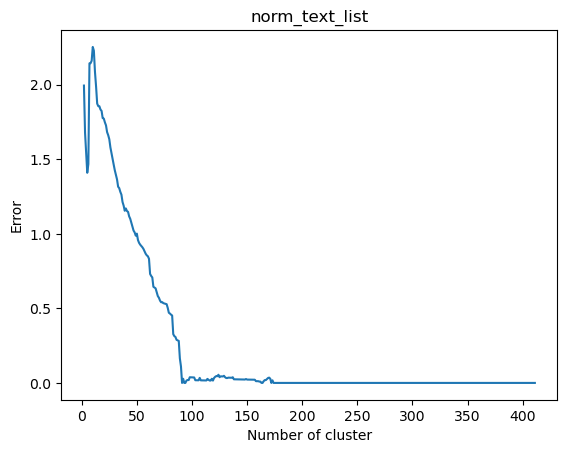

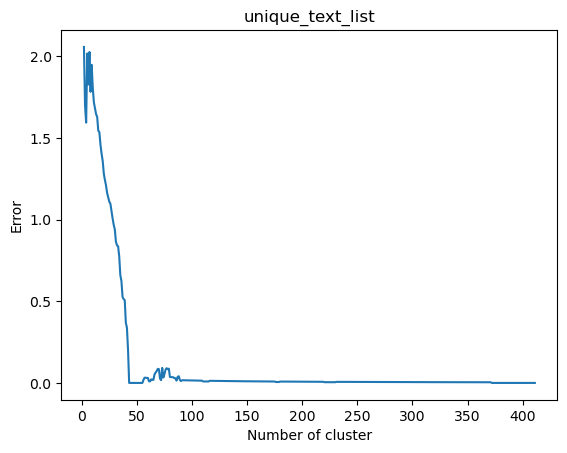

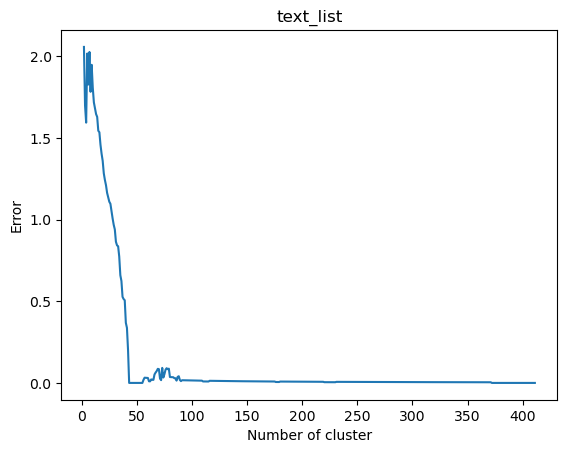

In [47]:
max_k = len(data)

for d in ht_models_wv.keys():
    scores = get_best_k(ht_models_wv[d], max_k)
    plt.figure()
    plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
    plt.xlabel("Number of cluster")
    plt.ylabel("Error")
    plt.title(f'{d}')
    plt.show()

По приведенным картинкам явно можно понять, что что-то происходит не так. Скорее всего, проблема в слишком небольшом количестве предложений небольшой длинны. `Word2Vec` видит их слишком одинаковыми: ![человек-паук](https://pulse.imgsmail.ru/imgpreview?mb=pulse&key=pic6210181742641957924)

### Попытка не пытка. Дубль 2

In [49]:
model = Word2Vec(sentences=data['text'], vector_size=100, workers=1, seed=42)

In [52]:
data['norm_text_list2'] = data['norm_text'].apply(lambda x: x.split(' '))
data['unique_text_list2'] = data['unique_text'].apply(lambda x: x.split(' '))
data['text_list2'] = data['text'].apply(lambda x: x.split(' '))

In [53]:
text_list2 = vectorize2(data['text_list2'], model)
norm_text_list2 = vectorize2(data['norm_text_list2'], model)
unique_text_list2 = vectorize2(data['unique_text_list2'], model)

In [54]:
ht_models_wv2 = dict()

ht_models_wv2['norm_text_list2'] = norm_text_list2
ht_models_wv2['unique_text_list2'] = unique_text_list2
ht_models_wv2['text_list2'] = text_list2

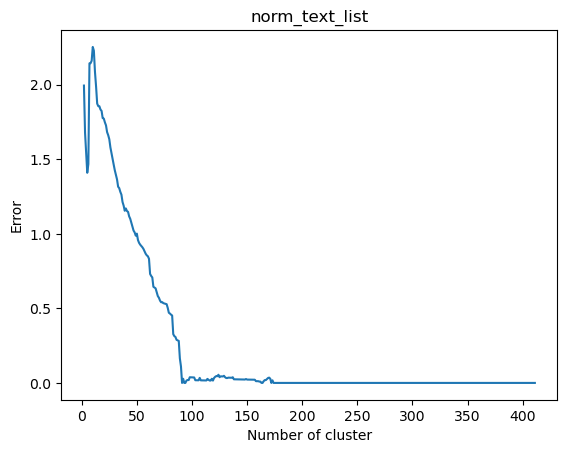

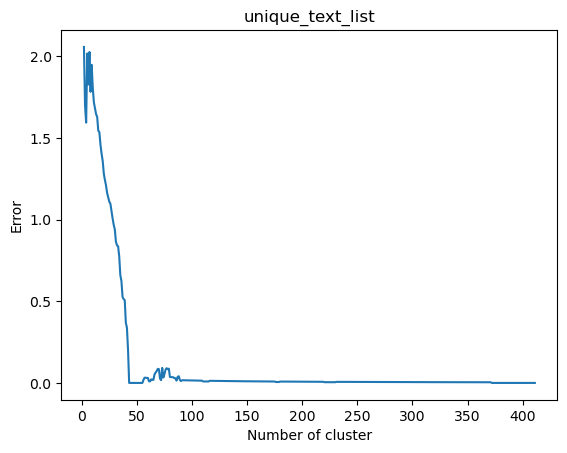

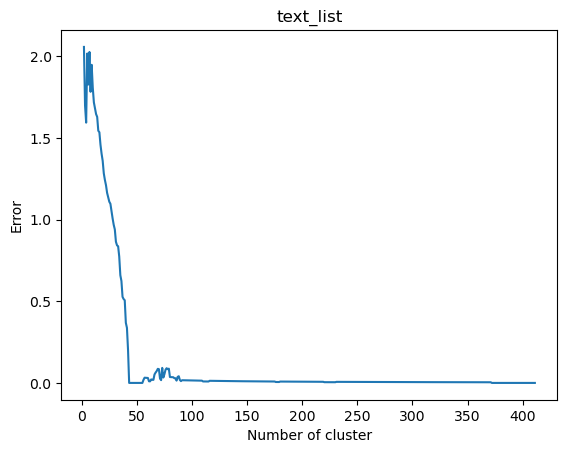

In [55]:
max_k = len(data)

for d in ht_models_wv.keys():
    scores = get_best_k(ht_models_wv[d], max_k)
    plt.figure()
    plt.plot(scores['n_clusters'].to_list(), scores['davies_bouldin_score'].to_list())
    plt.xlabel("Number of cluster")
    plt.ylabel("Error")
    plt.title(f'{d}')
    plt.show()

Таким образом, технология `Word2Vec` бесполезна в текущем решении